# Network inference from Brian network

In [1]:
from brian2 import *
import pandas as pd
%matplotlib inline

new_net = False

Nneurons_obs = 6  # number of neurons whose spike trains are observed
Nneurons_tot = 1000  # number of neurons in total;
sim_t = 300*second #simulation time

### Network

In [2]:
if new_net==True: #only simulate new network if required
    
    ######################
    ##### PARAMETERS #####
    ######################

    
    N_e = int(0.8*Nneurons_tot) #number of excitatory neurons
    N_i = Nneurons_tot - N_e #number of inhibitory neurons
    
    # neuron model parameters:
    taum = 20*ms
    taue = 5*ms
    taui = 10*ms
    Vt = -50*mV
    Vr = -60*mV
    El = -49*mV
    T_ref = 0.0*ms
    pe = 0.1 #excitatory connection probability
    pi = 0.1 #inhibitory connection probability
    
    # input parameters:
    np.random.seed(20)
    
    ## parameters for data generation:
    #d = '0.1*ms + 0.25*ms * randn()'  # synaptic delay
    #input_cc = 0.0  # determines the correlation strength of external input fluctuations 
                    # for each pair in the network 
    
    
    print('Number of excitatory neurons:',N_e)
    print('Number of inhibitory neurons:',N_i)
    
    ######################
    ###### NETWORK #######
    ######################
    
    start_scope()
    
    eqs = '''
    dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
    dge/dt = -ge/taue : volt
    dgi/dt = -gi/taui : volt
    
    
    '''
    
    # neurons
    G = NeuronGroup(Nneurons_tot, eqs,method='exact',
                    threshold='v>Vt',
                    reset='v=Vr',
                    refractory=T_ref)
    
    # intial values
    G.v = 'Vr + rand() * (Vt - Vr)'
    G.ge = 0.0
    G.gi = 0.0
    #G.rates = '10*Hz + i*Hz' #each neurons rate
    #G.size = '(100-i)/100. + 0.1' #each neurons input amplitude
    #G.mu = mu_vals*mV/ms
    
    # synapses
    Se = Synapses(G, G, 'we:volt', on_pre='ge += we')
    Si = Synapses(G, G, 'wi:volt', on_pre='gi += wi')
    Se.connect('i<=N_e and i!=j',p=pe)
    Si.connect('i>N_e and i!=j',p=pi)
    Se.we = np.ones(len(Se.i))*(60*0.27/10)*mV#np.random.rand(len(Se.i))*mV # random excitatory synaptic weight (voltage)
    Si.wi = np.ones(len(Si.i))*(-20*4.5/10)*mV#-np.random.rand(len(Si.i))*mV # random inhibitory synaptic weight
    #Se.delay = d
    #Si.delay = d
    
    # spikes
    spikemon = SpikeMonitor(G,record=True)
    
    run(sim_t)
    
    # spiketimes of observed neurons into dictionary for connectivity inference later
    obs_neurons_ind = np.random.permutation(Nneurons_tot)[:Nneurons_obs]
    
    # discard first 5 seconds
    sptimes = spikemon.t/ms
    spid = spikemon.i
    spid = spid[sptimes>5000]
    sptimes = sptimes[sptimes>5000]
    sptimes -= 5000
    
    ### visualize connections
    #visualise_connectivity(Se)
    #visualise_connectivity(Si)
    
    # weights
    Jmat = np.zeros((Nneurons_tot,Nneurons_tot))
    for ni,nj,w in zip(Se.i, Se.j, Se.we): #excitatory weights
        Jmat[ni,nj] = w/mV
    for ni,nj,w in zip(Si.i, Si.j, Si.wi): #inhibitory weights
        Jmat[ni,nj] = w/mV
        
    Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons
    
    # save data as pandas dataframe
    df = pd.DataFrame(columns=['spiketimes','spikeid','Nobs','Ntot','Jmat','Jmat_obs','obs_neurons','sim_time'])
    df = df.append({'spiketimes':sptimes,
                       'spikeid':np.array(spid),
                        'Nobs':Nneurons_obs,
                       'Ntot':Nneurons_tot,
                       'Jmat':Jmat,
                       'Jmat_obs':Jmat_obs,
                    'obs_neurons':obs_neurons_ind,
                        'sim_time':sim_t/second
                      }, ignore_index=True)
    
    df.to_pickle('data_N'+str(Nneurons_tot)+'_T'+str(int(sim_t/second))+'.pkl')


### Load already existing data

WARNING    /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


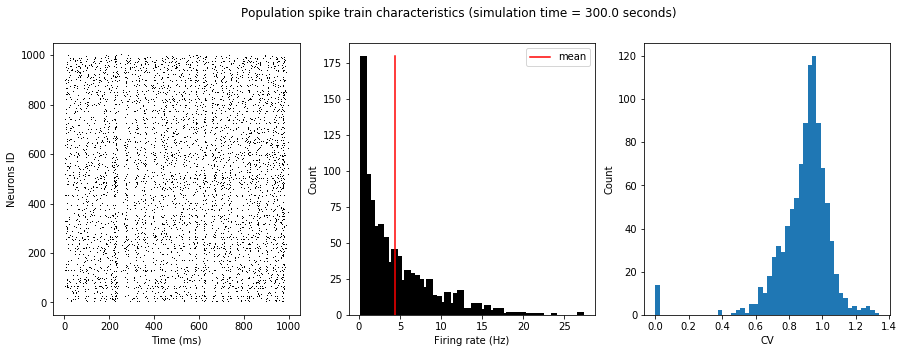

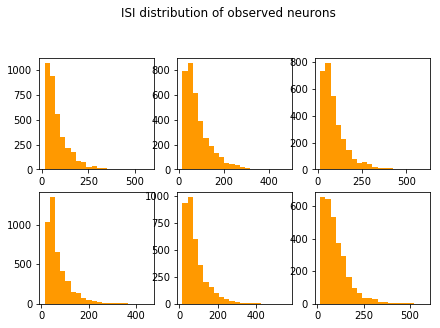

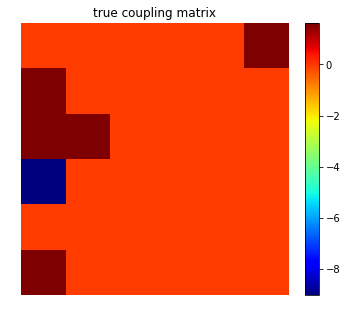

In [3]:
# load data --------------
if new_net==False:
    df = pd.read_pickle('data_N1000_T300.pkl')
sptimes = df['spiketimes'][0]
spid = df['spikeid'][0]
Nneurons_obs = df['Nobs'][0]
Nneurons_tot = df['Ntot'][0]
Jmat = df['Jmat'][0]
Jmat_obs = df['Jmat_obs'][0]
sim_t = df['sim_time'][0]

# VISUALIZE SPIKE PROPERTIES OF OBSERVED NEURONS --------------
ISI = {}
ISIstat = {
    'count':np.zeros(Nneurons_tot),
    'mean': np.zeros(Nneurons_tot),
    'std':np.zeros(Nneurons_tot),
    'cv':np.zeros(Nneurons_tot)
}
for i_N in range(Nneurons_tot):
    ISI[i_N] = np.diff(sptimes[spid==i_N])
    ISIstat['count'][i_N] = len(ISI[i_N])
    if ISIstat['count'][i_N]!=0:
        ISIstat['mean'][i_N] = np.mean(ISI[i_N])
        ISIstat['std'][i_N] = np.std(ISI[i_N])
        ISIstat['cv'][i_N] = np.std(ISI[i_N])/np.mean(ISI[i_N])
    else:
        ISIstat['cv'][i_N] = 0
        
figure(figsize=(15,5))
suptitle('Population spike train characteristics (simulation time = '+str(sim_t)+' seconds)')
# raster
subplot(131)
plot(np.array(sptimes)[np.array(sptimes)<1000],np.array(spid)[np.array(sptimes)<1000],'k,',lw=0)
ylabel('Neurons ID')
xlabel('Time (ms)')

# firing rate
subplot(132)
fr = 1/(ISIstat['mean']/1000)
fr[np.isinf(fr)] = 0
count,edges = np.histogram(fr,bins=50)
bar(edges[1:]-edges[:-1]+edges[:-1],count,facecolor='k')
plot([np.mean(fr),np.mean(fr)],[0,np.max(count)],'r',label='mean')
xlabel('Firing rate (Hz)')
ylabel('Count')
legend()

# coefficient of variation
subplot(133)
hist(ISIstat['cv'],50)
xlabel('CV')
ylabel('Count')
savefig('population.pdf')

figure(figsize=(7,7))
suptitle('ISI distribution of observed neurons')

# change observed neurons id to neurons with at least mean fr=5 Hz
np.random.seed(100)

obs_neurons_ind = np.random.choice(np.where(fr>=10)[0],Nneurons_obs)
Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons
for i_N,ind in enumerate(obs_neurons_ind):
    subplot(3,3,i_N+1)
    hist(ISI[ind],20,facecolor=[1,0.6,0])
savefig('ISI_dist.pdf')
show()

# into dictionary
Spt_dict = {}
for i_N,id_N in enumerate(obs_neurons_ind):
    idx = np.where(spid == id_N)[0]
    Spt_dict[i_N] = sptimes[idx]
    
# visualize connectivity matrix    
figure(figsize=(6,5))
subplot(111)
imshow(Jmat_obs, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
title('true coupling matrix')
colorbar()
axis('off')
show()    


### Estimation

In [4]:
import inference_methods as im
import multiprocessing

# generate data with other method for comparison
params = dict()
# neuron model parameters:
params['tau_m'] = 20.0  # ms, membrane time constant
params['V_r'] = -60.0  # mV, reset voltage
params['V_s'] = -50.0  # mV, spike voltage
params['Delta_T'] = 0.0  # mV, threshold slope factor (set 0 for LIF model, 
                         #                                >0 for EIF model)  
params['V_T'] = -50.0  # mV, effective threshold voltage (only used for EIF)
params['T_ref'] = 0.0  # ms, refractory duration

d = 0.0  # ms, delay

# example data:
## input parameters:
#np.random.seed(20)
#mu_vals = -1.75 * (0.8 + 0.4*np.random.rand(Nneurons_tot))  # mV/ms, input mean
#sigma_vals = 2.5 * (0.8 + 0.4*np.random.rand(Nneurons_tot))  # mV/sqrt(ms), input
#                                                             # standard deviation
#
#
#    
## parameters for data generation:
#Jmat = 1.5*np.random.rand(Nneurons_tot,Nneurons_tot) - 0.75  # coupling strengths
#Jmat -= np.diag(np.diag(Jmat))  # exclude autapses
#input_cc = 0.0  # determines the correlation strength of external input fluctuations 
#                # for each pair in the network 
#t_end = 30e4  # ms, simulation duration ("recording time")
#params['dt_sim'] = 0.05  # ms, simulation time step
#
## GENERATE SPIKE TRAINS from network model --------------------------------
#tgrid = np.arange(0, t_end+params['dt_sim']/2, params['dt_sim'])
#        # time points for simulation
#
#V_init = params['V_r'] * np.ones(Nneurons_tot)
#
#start = time.time()
#randnvals = np.random.randn(Nneurons_tot,len(tgrid))
#randnvals_c = np.random.randn(len(tgrid)) # common noise
#print('')
#print('starting network simulation') 
#Spt_dummy, sp_counts, _ = \
#    im.simulate_EIF_net_numba(tgrid, V_init, params['tau_m'], params['V_s'], 
#                              params['V_r'], params['V_T'], params['Delta_T'], 
#                              params['T_ref'], mu_vals, sigma_vals, Jmat, d, 
#                              input_cc,randnvals,randnvals_c)
#Spt_dict = {}
#for i_N in range(Nneurons_obs):
#    if sp_counts[i_N]>0:
#        Spt_dict[i_N] = Spt_dummy[i_N,Spt_dummy[i_N,:]>0]
#    else:
#        Spt_dict[i_N] = np.array([])
#
#del Spt_dummy
#
#print('network simulation took {dur}s'.format(
#      dur=np.round(time.time() - start,2)))
#print('')
#
#Jmat_obs = Jmat[:Nneurons_obs,:][:,:Nneurons_obs]

starting estimation using 3 parallel processes

likelihood optimization can take several minutes...
mean ISI of neuron 1 = 82.62
mean ISI of neuron 2 = 83.74
mean ISI of neuron 3 = 96.28
neuron 2: mu_estim = -2.64, sigma_estim = 0.79
('t_pert_max:', 323.3)
neuron 3: mu_estim = -2.65, sigma_estim = 0.75
('t_pert_max:', 367.0)
neuron 1: mu_estim = -2.64, sigma_estim = 0.82
('t_pert_max:', 321.1)


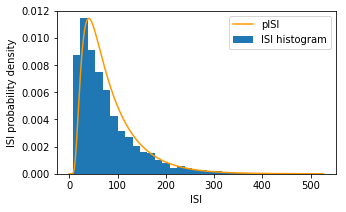

precalculations for neuron 2 took 147.59s
mean ISI of neuron 4 = 69.46
1 of 6 estimation parts completed


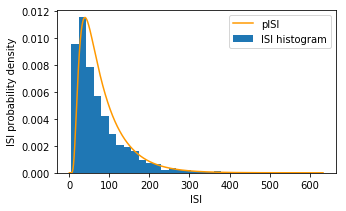

precalculations for neuron 1 took 184.65s
neuron 4: mu_estim = -2.6, sigma_estim = 0.74


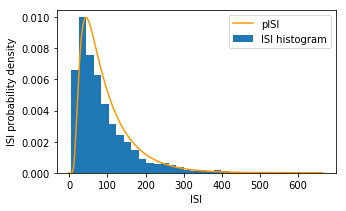

precalculations for neuron 3 took 193.17s
('t_pert_max:', 261.3)
mean ISI of neuron 5 = 84.06
2 of 6 estimation parts completed
mean ISI of neuron 6 = 99.55
3 of 6 estimation parts completed
neuron 5: mu_estim = -2.61, sigma_estim = 0.69
('t_pert_max:', 314.6)
neuron 6: mu_estim = -2.65, sigma_estim = 0.74
('t_pert_max:', 379.0)


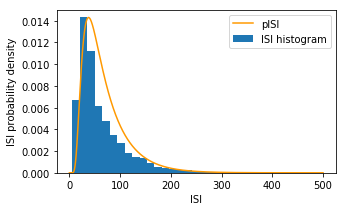

precalculations for neuron 4 took 153.31s
4 of 6 estimation parts completed


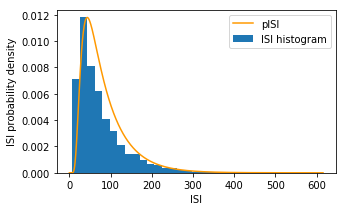

precalculations for neuron 5 took 170.01s


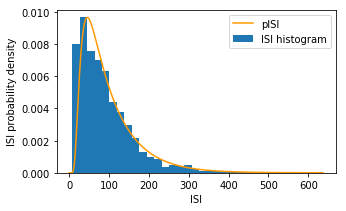

precalculations for neuron 6 took 169.87s
5 of 6 estimation parts completed
6 of 6 estimation parts completed

estimation took 378.16s, corr.-coeff. = 0.113800391622



In [5]:
# parameters for estimation (method 1a)
params['pISI_method'] = 'fourier'
f_max = 2000.0 # Hz, determines resolution (accuracy) of ISI density; 
               # 1k seems sufficient in many cases, for finer resolution try 2k or 4k
d_freq = 0.25 # Hz, spacing of frequency grid
d_V = 0.025  # mV, spacing of voltage grid
params['V_lb'] = -150.0  # mV, lower bound
params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
params['freq_vals'] = np.arange(0.0, f_max+d_freq/2, d_freq)/1000  # kHz
params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                    # index of reset voltage on grid, this should be a grid point
                    
# parameters for estimation when using the finite volume method instead of the 
# Fourier method to calculate p_ISI^1, which is optional (and often faster)
use_fvm = True  # False: using Fourier method
if use_fvm:
    params['pISI_method'] = 'fvm' 
    d_V = 0.025  # mV, spacing of voltage grid
    params['V_lb'] = -150.0  # mV, lower bound
    params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
    params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                        # index of reset voltage on grid, this should be a grid point
    params['neuron_model'] = 'LIF'
    params['integration_method'] = 'implicit'
    params['N_centers_fvm'] = 1000  # number of centers for voltage discretization
    params['fvm_v_init'] = 'delta'  # voltage density initialization
    params['fvm_delta_peak'] = params['V_r']  # location of initial density peak
    params['fvm_dt'] = 0.1  # ms, time step for finite volume method
                            # 0.1 seems ok, prev. def.: 0.05 ms 

sigma_init = 3.0  # initial sigma value (initial mu value will be determined by 
                  # sigma_init and empirical mean ISI)
N_tpert = 300  # determines spacing of (potential) perturbation times within ISIs
               # due to coupling; def.: 300            
J_bnds = (-3.0, 3.0)  # mV, min./max. coupling strength 
N_procs = int(5.0*multiprocessing.cpu_count()/6)  # number of parallel processes                
             

        
# ESTIMATE PARAMETERS from spike trains -----------------------------------
start = time.time()
N = len(Spt_dict.keys())
args_fixed = (Spt_dict, d, sigma_init, N_tpert, J_bnds, Jmat, params)
arg_tuple_list = [(iN, N, args_fixed) for iN in range(N)]    
                                                          
print('starting estimation using {} parallel processes'.format(N_procs))
# e.g., one process for each neuron
print('')
print('likelihood optimization can take several minutes...')
pool = multiprocessing.Pool(N_procs)
if use_fvm:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v1, arg_tuple_list)
else:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v2, arg_tuple_list)

D = {}
obs_neurons_id = list(Spt_dict.keys())
D['J_true'] = Jmat_obs
D['mu_estim'] = np.zeros(N)*np.nan
D['sigma_estim'] = np.zeros(N)*np.nan
D['logl_uncoupled'] = np.zeros(N)*np.nan
D['J_estim'] = np.zeros((N,N))
D['logl_coupled'] = np.zeros((N,N))*np.nan

finished = 0 
for i_N, mu_estim, sigma_estim, logl_uncoupled, \
    J_estim_row, logl_coupled_row in result:
    finished += 1
    print(('{count} of {tot} estimation parts completed').
          format(count=finished, tot=N)) 
    D['mu_estim'][i_N] = mu_estim
    D['sigma_estim'][i_N] = sigma_estim
    D['logl_uncoupled'][i_N] = logl_uncoupled
    D['J_estim'][i_N,:] = J_estim_row
    D['logl_coupled'][i_N,:] = logl_coupled_row

pool.close()
Pcc = np.corrcoef(np.ravel(D['J_estim']),np.ravel(D['J_true']))
print('')
print('estimation took {dur}s, corr.-coeff. = {cc}'.format(
       dur=np.round(time.time() - start,2), cc=Pcc[0,1]) )
print('')
         



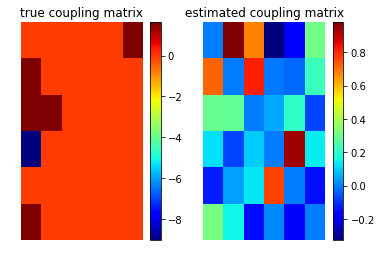

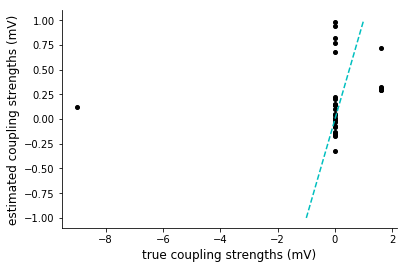

In [6]:
import matplotlib.pyplot as plt
# PLOT --------------------------------------------------------------------
plt.figure()
plt.subplot(121)
plt.imshow(D['J_true'], origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
plt.title('true coupling matrix')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(D['J_estim'], origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
plt.title('estimated coupling matrix')
plt.colorbar()
plt.axis('off')

plt.figure()
ax = plt.subplot()
idx = np.diag(np.ones(N))<1
plt.plot(np.ravel(D['J_true'][idx]), np.ravel(D['J_estim'][idx]), 'ok', 
         markersize=4)
plt.plot([-1, 1], [-1, 1], 'c--')
plt.xlabel('true coupling strengths (mV)', fontsize=12)
plt.ylabel('estimated coupling strengths (mV)', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')